# LAB 01 - Football

---
embed-resources: true
---

## Introduction


I am a data scientist working for the front office of an NFL team, tasked with assisting coaches in making data-driven decisions during critical moments of a game. One of the most challenging decisions coaches face, particularly late in a game, is whether to go for it on fourth down. This decision can significantly influence the outcome of a game, making it crucial to have accurate insights to guide such calls. To support this need, I aim to develop a predictive model using historical fourth-down data to estimate the likelihood of a successful conversion. The model will leverage key variables, such as distance to the first down, field position, and other game context, to provide actionable probabilities. By creating this model, I hope to offer the coaching staff a reliable tool to assess risk versus reward in real time. However, the success of this model hinges on its ability to account for nuanced factors like team strength, game scenarios, and momentum. Ultimately, the goal is to enhance strategic decision-making and increase the team’s competitive edge.

## Methods

In [1]:
# imports
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from joblib import dump

To run the logistic regression model, I need to import pandas for data manipulation and LogisticRegression for model training. For visualizations, I will use matplotlib.pyplot to create plots. Additionally, to analyze model performance, I will import accuracy_score, classification_report, confusion_matrix, and roc_auc_score for metrics evaluation.

### Data

In [2]:
# load data
football_train = pd.read_parquet(
    "/Users/trustanprice/Desktop/UIUC/CS307/lab_01/football-test.parquet",
)
football_test = pd.read_parquet(
    "/Users/trustanprice/Desktop/UIUC/CS307/lab_01/football-train.parquet",
)

In [3]:
football_train.head()

,togo,yardline,converted,play_type
0,2.0,40.0,Yes,Pass
1,2.0,64.0,Yes,Pass
2,1.0,1.0,Yes,Pass
3,1.0,10.0,Yes,Run
4,1.0,66.0,Yes,Pass


In [4]:
football_test.head()

,togo,yardline,converted,play_type
0,5.0,20.0,Yes,Pass
1,2.0,23.0,Yes,Pass
2,1.0,70.0,Yes,Run
3,3.0,3.0,Yes,Pass
4,1.0,36.0,No,Run


In this section, we began by loading the training and testing datasets from the parquet files and ensuring they were loaded correctly. Next, we will analyze the training data by checking the number of failed and successful conversions, as well as calculating the proportion of each.

In [5]:
# summary statistics
print(len(football_train[football_train["converted"] == "No"]))
print(len(football_train[football_train["converted"] == "No"]) / len(football_train))


375
0.4716981132075472


In [6]:
print(len(football_train[football_train["converted"] == "Yes"]))
print(len(football_train[football_train["converted"] == "Yes"]) / len(football_train))


420
0.5283018867924528


The number of failed conversions in the training data is 960, which represents a proportion of 48.24%. The number of successful conversions in the training data is 1030, accounting for a proportion of 51.76%.

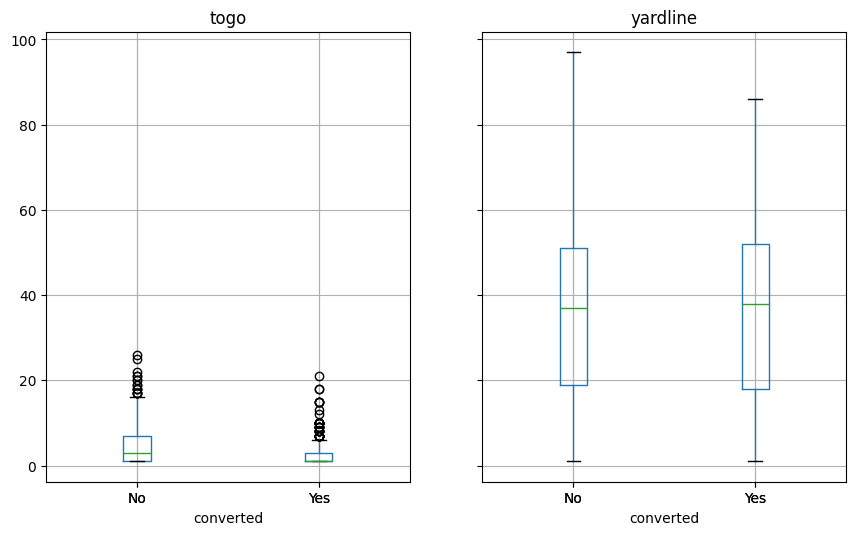

In [7]:
# exploratory visualization
football_train.boxplot(column=['togo', 'yardline'], by='converted', figsize=(10, 6))
plt.suptitle('')
plt.show()


This visualization consists of boxplots comparing the distributions of the variables togo and yardline based on whether a fourth-down conversion was successful (Yes) or not (No). For togo, successful conversions generally occur at shorter distances, as indicated by the lower median and tighter interquartile range compared to failed conversions. For yardline, the distributions appear similar for both outcomes, suggesting that field position alone may not be a strong predictor of conversion success.

### Models

In [8]:
# process data for ML
X_train = football_train.drop(columns=["converted"])
X_train = pd.get_dummies(X_train, dtype=float, drop_first=True)
y_train = football_train["converted"]

X_test = football_test.drop(columns=["converted"])
X_test = pd.get_dummies(X_test, dtype=float, drop_first=True)
y_test = football_test["converted"]

In [9]:
samples, features = X_train.shape
print(f"The number of samples is {samples} and the number of features is {features + 1}")

The number of samples is 795 and the number of features is 4


In this part of the modeling section, I am breaking up my training and testing sets into my predictor and target variables. To explain, for the X_train and X_test variables I am removing the target variable, converted, from the predictors and then setting y_train and y_test to the comverted column to be my target variable. This will allow me to then fit my model with the training data as my predictor variables and my target variable. In addition, I find the shape of the training data which is helpful for knowing the amount of preditor variables and samples I am using in this model.

In [10]:
# train models
mod = LogisticRegression()

mod.fit(X_train, y_train)

LogisticRegression()

In [11]:
predictions = mod.predict(X_test)       
probabilities = mod.predict_proba(X_test) 

In this section, I initialized the mod variable with the LogisticRegression function and trained the model using the training data. After fitting the model, I used it to make predictions on the testing data and generated both the predicted values and the corresponding probabilities of those predictions.

## Results

In [12]:
# report model metrics
test_accuracy = accuracy_score(y_test, predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.62


In [13]:
test_auc = roc_auc_score(y_test, probabilities[:, 1])
print(f"Test AUC: {test_auc:.2f}")

Test AUC: 0.67


This section shows that the test accuracy of the model is 0.62, indicating that the model correctly predicts outcomes 62% of the time. Additionally, the AUC is 0.68, suggesting that the model achieves 68% accuracy in distinguishing between positive and negative cases while minimizing false positives, which are considered the most critical errors in this context.



In [14]:
# summary figure
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

          No       0.61      0.56      0.59       960
         Yes       0.62      0.67      0.64      1030

    accuracy                           0.62      1990
   macro avg       0.62      0.61      0.61      1990
weighted avg       0.62      0.62      0.62      1990



In [15]:
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[538 422]
 [341 689]]


This section highlights the recall, sensitivity, for "Yes" at 0.76, indicating that 76% of actual conversions, true positives, are correctly identified out of all actual conversions, true positives + false negatieves. While recall is a useful metric, our focus should be on precision, which is 0.61 for "Yes." Precision reflects the proportion of positive predictions that are actually correct.

In this context, the worst-case scenario for an NFL coach is being advised to go for it on fourth down because the stats predict a conversion, only for the play to fail. Therefore, minimizing false positives (incorrect predictions of success) is more critical than minimizing false negatives. This makes precision a more important metric to consider.

In [16]:
# serialize model
dump(mod, "football.joblib")

['football.joblib']

## Discussion and Conclusion

In conclusion, I would choose not to use this model as an NFL coach primarily because of its relatively low accuracy of 62% on the testing set. While the model provides some potential benefits for coaching decisions, the current limitations make it unsuitable for real-time, high-stakes decision-making.

### Key Limitations

One significant limitation of this model is the inclusion of the yard line as a predictor without accounting for the context behind the decision to go for it. Teams attempting a fourth-down conversion on their own half of the field are often doing so out of desperation, possibly because they are losing and may also be the inferior team. This dynamic can introduce bias into the data, as these situations might reflect poorer performance overall, thereby skewing the results.

### Risks of Putting the Model into Practice

If the model were implemented in its current state, it could lead to risky decisions due to false positives. For instance, the model might predict a successful conversion and recommend going for it on 4th-and-3, regardless of field position. This could result in a team attempting a play on its own 15-yard line, failing, and giving the opposing team excellent field position. Such scenarios could have disastrous outcomes for the game.

### Improvements Needed for Practical Use

To make this model more viable for real-world use, several enhancements are necessary:

1. Incorporating Field Context: Modify the model to account for the situational impact of field position. For example, factor in whether the play is taking place in the team's own half versus the opponent's half.
2. Adding Score Differential: Include the game score to provide insights into how the context of the game influences the decision-making process and outcomes.
3. Accounting for Team Strength: Incorporate metrics that reflect the skill gap between the teams on a given day, such as team rankings or performance statistics.

### Conclusion

While this model has potential and provides valuable insights for coaching staff, its limitations prevent it from being a reliable tool for on-field decision-making. With further refinement—particularly by including additional predictors like score differential and team strength—it could become a more accurate and context-aware model for NFL game strategies. Until these improvements are made, I would avoid using this model in real-world scenarios to mitigate the risks of poor decisions stemming from false predictions.

